In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import glob
import json
import time
import pathlib
import tarfile
import requests

import numpy as np
import tensorflow as tf
old_v = tf.compat.v1.logging.get_verbosity()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from PIL import Image
from shutil import move
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory

abspath = os.getcwd()
datapath = os.path.join(abspath, "dataset")
parampath = os.path.join(abspath, "param")

def get_session(memory_limit=8192):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])
        except RuntimeError as e:
            print(e)

class Dataset:
    
    def getImages(self):
        return self.data
    
    def processData(self, batch_size=32, img_height=180, img_width=180):
        """
        Prepare batches of images
        """
        
        self.data_dir = pathlib.Path(self.data_dir)
        
        print("[DATASET-%s]"%(type(self).__name__), end=' ')
        
        train_ds = image_dataset_from_directory(self.data_dir,
                                                validation_split=0.1,
                                                subset="training",
                                                seed=9449,
                                                image_size=(img_height, img_width),
                                                batch_size=batch_size)#.map(normalize)
        
        val_ds = image_dataset_from_directory(self.data_dir,
                                              validation_split=0.1,
                                              subset="validation",
                                              seed=9449,
                                              image_size=(img_height, img_width),
                                              batch_size=batch_size)#.map(normalize)
        
        self.data = {'train_ds':train_ds, 'val_ds':val_ds}
        self.class_names = np.array(sorted([item.name for item in self.data_dir.glob('*') if item.name != "LICENSE.txt"]))

    def showSamples(self, nrows=5, ncols=5):
        """
        Plot nrows x ncols images
        """
        def normalize(image, label):
            image = tf.cast(image/255., tf.float32)
            return image, label
        
        if nrows > 32 or ncols > 32 :
            print("Please select the rows/columns less than or equal to 32")
            return
        
        plt.figure(figsize=(10, 10))
        for image_batch, label_batch in self.data['train_ds']:
            for i in range(nrows*ncols):
                ax = plt.subplot(nrows, ncols, i + 1)
                plt.imshow(image_batch[i]/255.)
                plt.title(self.class_names[label_batch[i]])
                plt.axis("off")
            break    
    
class Flower5(Dataset):

    def __init__(self):
        global datapath
        
        src = os.path.join(datapath, "flower5.tar.gz")
        
        self.data_dir = os.path.join(datapath, "flower5")
        
        if not os.path.exists(self.data_dir):
            data_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
        
            tf.keras.utils.get_file(origin=data_url, fname=self.data_dir, untar=True)
        
            tarfile.open(src).extractall(datapath)
        
            os.rename(datapath+"/flower_photos", self.data_dir)
        
        self.processData()
        
class Flower102(Dataset):

    def __init__(self):
        global datapath
        
        src = os.path.join(datapath, "flower102.tgz")
        
        self.data_dir = os.path.join(datapath, "flower102")

        label_path = os.path.join(datapath, "imagelabels.mat")
        
        if not os.path.exists(label_path):
            requests.get('https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat', allow_redirects=True)

        if not os.path.exists(self.data_dir):
            os.mkdir(self.data_dir)
    
            data_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"

            tf.keras.utils.get_file(origin=data_url, fname=self.data_dir, untar=True)
        
            tarfile.open(src).extractall(datapath)
            
            with open('label.json') as f:
                class_name = json.load(f)
    
            classes = len(class_name.keys())
        
            for i in range(classes):
                class_dir = os.path.join(self.data_dir, class_name[str(i)])
                os.mkdir(class_dir)
    
            labels = loadmat(label_path)['labels'][0] - 1

            images = sorted(glob.glob(os.path.join(datapath, 'jpg', '*.jpg')))

            for image, label in zip(images, labels):
                new_image = os.path.join(self.data_dir, class_name[str(label)], str(image).split(os.sep)[-1])
                move(image, new_image)
    
            os.rmdir('dataset/jpg')
        
        self.processData()
        
        
class Model:
    """
    Creates a baseline model that will be trained on either '102 flower photos' or '5 flower photos' dataset
    """

    def __init__(self, classes):
        self.build(classes=classes)
        
    def build(self, img_height=180, img_width=180, classes=5):
        self.nn = models.Sequential([
            layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
            layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
            layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
            layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
            layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(classes)
        ])
        
        self.nn.summary()
        self.nn.compile(optimizer='Adam',
                        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])
        
    def copy(self, ckpt_name, freeze_layers=[]):
        global parampath
        
        ckpt = os.path.join(parampath, ckpt_name)
        nn = models.load_model(ckpt)
        
        layers = self.nn.layers
        
        for l in freeze_layers:
            if l > len(layers):
                print("Invalid layer index")
                
            layers[l].set_weights(nn.layers[l].get_weights())
            layers[l].trainable = False
        
        self.nn.compile(optimizer='Adam',
                        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])        
        
        
    def train(self, data, ckpt_name):
        global parampath
        
        history_callback = self.nn.fit(data['train_ds'],
                                       epochs = 10,
                                       batch_size=32)
        
        ckpt = os.path.join(parampath, ckpt_name)
        self.nn.save(ckpt)
        
        return history_callback.history["accuracy"]
    
def visualize_acc(reports, maxiter=10):
    """
    Plot accuracy
    """
    
    plt.rc('font',family='DejaVu Sans', size=16)
    fig=plt.figure(figsize=(5, 4.5))
    ax=fig.add_axes([0,0,1,1])
    
    mark = ["o", "^"]
    
    for model_name, acc in reports.items() :
        plt.plot(list(range(0, maxiter+1)),
                 [0.0]+acc[:maxiter],
                 label=model_name,
                 marker=mark[0],
                 markersize=10,
                 linewidth=3,
                 clip_on=False)
        del mark[0]

    ax.set_xlim([0, maxiter])
    ax.set_ylim([0.0, 1.0])
    ax.set_xticks(list(range(0, maxiter+1, maxiter//5)))
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xticks(range(0, maxiter+1, maxiter//10), minor=True)
    ax.set_yticks([i/10 for i in range(0, 11)], minor=True)
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("Accuracy", fontsize=20)
    ax.legend(markerscale=1, fontsize=16, loc='lower right')
    ax.grid(which='both', color='#BDBDBD', linestyle='--', linewidth=1)
    plt.rc('font',family='DejaVu Sans', size=16)

    plt.show()

if __name__ == '__main__':
    get_session(memory_limit=8192)

## Dataset

To start, you will download **two flower photo datasets** each of which has **5 and 102 flower categories**, respectively

Run the next cell to load the **5 Flower** dataset you are going to use.

It also will show you an example of a labelled image in the dataset.

[DATASET-Flower5] Found 3670 files belonging to 5 classes.
Using 3303 files for training.
Found 3670 files belonging to 5 classes.
Using 367 files for validation.


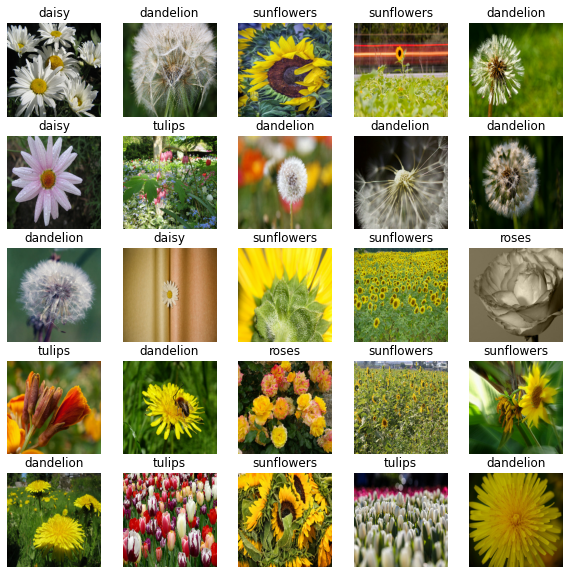

In [2]:
datasetA = Flower5()
datasetA.showSamples(nrows=5, ncols=5)

You can also download and visualize examples of **102 Flower** dataset by running the below cell.

This dataset has more samples and flower categories than the previous one.

[DATASET-Flower102] Found 8189 files belonging to 102 classes.
Using 7371 files for training.
Found 8189 files belonging to 102 classes.
Using 818 files for validation.


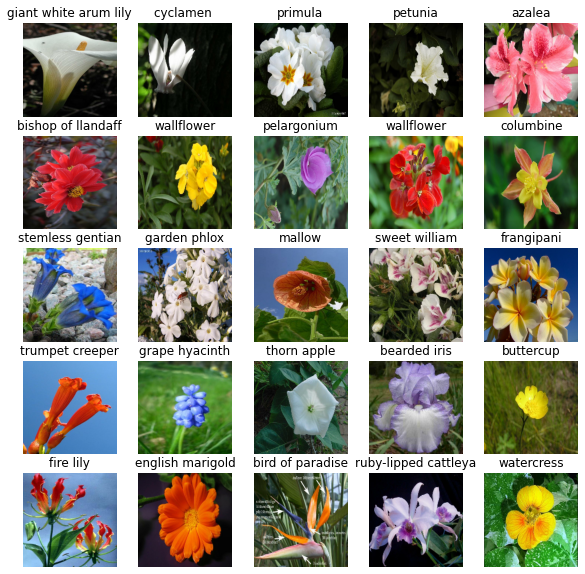

In [3]:
datasetB = Flower102()
datasetB.showSamples(nrows=5, ncols=5)

## Model (baseline)

Now that you have imported the datasets, you are going to build **a simple CNN model** consisting of **4 convolutional neural networks** and **3 fully-connected networks**.

Feel free to modify the model topology if you want.

Run the following cells to train **5 flowers dataset** on your model for 10 epochs.

In [4]:
M5 = Model(classes=5)
res = M5.train(datasetA.getImages(), 'flower5.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 32)        0

## Model (without fine-tuning)

You will now train the **102 flowers dataset** within 10 epochs.

To verify how the **Fine-tuning** technique makes the pre-trained model (Flower5) be suited for the much difficult task having a large number of flower categories, you will compare the performance between a naive model (trained on 102 flowers dataset solely) and fine-tuned model.

Your first task is to build a new model that will be fed with **102 flowers dataset**.

In [5]:
reports = {}
M102 = Model(classes=102)
res = M102.train(datasetB.getImages(), 'flower102.h5')
reports['train_solely'] = res

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 21, 21, 32)       

## Model (withfine-tuning)

This time, you will train the **fine-tuned model**.

The new model copies the weights of convolutional layers of the baseline model (Flower5) and freezes those layers.

Only the subsequent 3 fully-connected neurons will be trained on the **102 flowers dataset**.

In [6]:
Mft = Model(classes=102)
Mft.copy('flower5.h5', [1,3,5,7])
res = Mft.train(datasetB.getImages(), 'flower_ft.h5')
reports['fine_tuning'] = res

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 21, 21, 32)       

Check how well the fine-tuned model improves its accuracy on the new dataset.

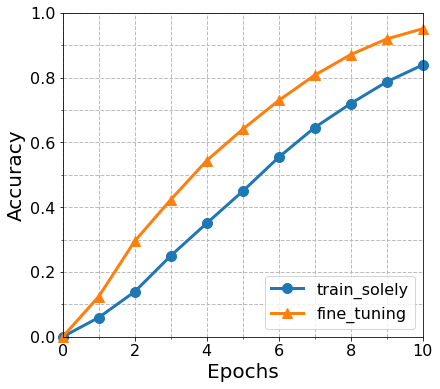

In [7]:
visualize_acc(reports)